# This is the code used for movie genre classification problem

## 1. First step is to import all the required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
import sys
import datetime as dt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

import glob
from collections import Counter
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from xgboost import XGBClassifier
from sklearn import model_selection, naive_bayes, svm
from gensim.models import Word2Vec

### 2. We load dataset downloaded from Kaggle

In [2]:
#read data from movie csv file
movie_data = pd.read_csv('./movie_data.csv', encoding='windows-1252', sep=',').astype(str)
print (movie_data.columns)
print(movie_data.shape)

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Number of words'],
      dtype='object')
(34896, 9)


### 3. This is to remove meaningless data in genre column. 
As we observed the dataset, there are many meaningless data which will polute the genre labels.
Number of rows has been reduced to 28813 rows

In [3]:
#Remove rows where genre is unknown
movie_data = movie_data[movie_data.Genre != 'unknown']
#Remove special characters
movie_data['Genre'] = movie_data['Genre'].str.replace('\W', ' ')
#Remove words with numbers
movie_data['Genre'] = movie_data['Genre'].str.replace('.*\d+', '')
#Remove words with less than 3 characters
movie_data['Genre'] = movie_data['Genre'].str.findall('\w{3,}').str.join(' ')
#Remove null column
movie_data = movie_data[movie_data['Genre'].notnull()]
movie_data.shape

(28813, 9)

### 4. Vecorize genre column for exploratory data analysis process

In [4]:
#Set genre vectorizer as Count Vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: re.split(r'[;,\s\/]\s*',x ))
genre_dtm = vectorizer.fit_transform(movie_data['Genre'])
print("Number of data points :", genre_dtm.shape[0])
print("Number of unique genres", genre_dtm.shape[1])

Number of data points : 28813
Number of unique genres 662


### 5. Assign all feature names to a list 'genres'

In [5]:
genres = vectorizer.get_feature_names()
print("some of the tags we have :", genres[:10])

some of the tags we have : ['', 'about', 'acclaimed', 'action', 'adaptation', 'adapted', 'adult', 'adventure', 'adventures', 'afghan']


### 6. Create a dictionary and store each genre value and its corresbonding frequencies in the dataset
In this list, we have found many genres only appear a few times. These data are not required in our dataset as they are not standard genre names

In [6]:
#store the document term matrix in a dictionary
freqs = genre_dtm.sum(axis=0).A1
result = dict(zip(genres, freqs))
print(result)

{'': 47, 'about': 3, 'acclaimed': 1, 'action': 2447, 'adaptation': 3, 'adapted': 3, 'adult': 34, 'adventure': 866, 'adventures': 1, 'afghan': 1, 'african': 9, 'agarwal': 1, 'age': 10, 'ago': 1, 'ahlawat': 1, 'aids': 1, 'ajay': 1, 'alexandre': 1, 'ali': 2, 'alice': 2, 'allari': 2, 'almost': 2, 'alzheimer': 1, 'american': 2, 'amperiani': 1, 'ancient': 3, 'and': 8, 'animated': 416, 'animation': 349, 'anime': 143, 'anthology': 17, 'anushka': 1, 'apocalyptic': 5, 'aquatics': 2, 'arctic': 1, 'arjun': 1, 'art': 5, 'arti': 1, 'artistic': 1, 'artists': 1, 'arts': 108, 'arya': 1, 'asin': 1, 'aswani': 1, 'auli': 1, 'australian': 2, 'avant': 7, 'aviation': 1, 'babu': 3, 'back': 2, 'bajwa': 1, 'balaji': 1, 'balakrishna': 1, 'ballard': 1, 'balu': 1, 'banks': 1, 'barua': 1, 'based': 14, 'bbc': 1, 'bernard': 1, 'bhagavaan': 1, 'bharath': 2, 'bhaskara': 1, 'bhavana': 1, 'bholenath': 1, 'bhoomika': 1, 'biblical': 10, 'bicycle': 2, 'biju': 1, 'biker': 10, 'bio': 21, 'biodrama': 5, 'biographic': 1, 'biogr

### 7. Save the list of genre frequencies in a file

In [7]:
#saving dictionary in a csv file
if not os.path.isfile('genre_counts_dict_dtm.csv'):
    with open ('genre_counts_dict_dtm.csv','w',newline='', encoding='utf-8')as csv_file:
        writer = csv.writer(csv_file)
        for key,value in result.items():
            writer.writerow([key,value])
genre_df=pd.read_csv("genre_counts_dict_dtm.csv",names=['Genres','Counts'])
genre_df.head()
genre_df = genre_df[genre_df['Genres'].notnull()]

### 8. Create a list of genres which have appearances less than 100 times

In [8]:
#create a list a and stores all the grenres that has an appearance less or equal to 5 times
genre_df['Counts'] = genre_df['Counts'].astype(float)
dictionary = np.where(genre_df.Counts<=99.0, genre_df.Genres, '')
#remove empty strings
dictionary = [string for string in dictionary if string != ""]
print(dictionary)

['about', 'acclaimed', 'adaptation', 'adapted', 'adult', 'adventures', 'afghan', 'african', 'agarwal', 'age', 'ago', 'ahlawat', 'aids', 'ajay', 'alexandre', 'ali', 'alice', 'allari', 'almost', 'alzheimer', 'american', 'amperiani', 'ancient', 'and', 'anthology', 'anushka', 'apocalyptic', 'aquatics', 'arctic', 'arjun', 'art', 'arti', 'artistic', 'artists', 'arya', 'asin', 'aswani', 'auli', 'australian', 'avant', 'aviation', 'babu', 'back', 'bajwa', 'balaji', 'balakrishna', 'ballard', 'balu', 'banks', 'barua', 'based', 'bbc', 'bernard', 'bhagavaan', 'bharath', 'bhaskara', 'bhavana', 'bholenath', 'bhoomika', 'biblical', 'bicycle', 'biju', 'biker', 'bio', 'biodrama', 'biographic', 'biographical', 'biogtaphy', 'biopic', 'black', 'blaxploitation', 'board', 'bond', 'bouchard', 'boxing', 'brahmanandam', 'bram', 'bramhanandam', 'british', 'bros', 'bruceploitation', 'buddy', 'business', 'but', 'camp', 'campus', 'can', 'canada', 'canadian', 'canadiens', 'cartoon', 'cbc', 'chakraborty', 'chakravart

### 9. Remove genres from previous saved list

In [9]:
#Update movie_data data frame with processed genres
movie_data['Genre'] = movie_data['Genre'].apply(lambda x: " ".join(x for x in x.split() if x.lower() not in dictionary))
movie_data['Genre'].replace('', np.nan, inplace=True)
movie_data.dropna(subset=['Genre'], inplace=True)
print(movie_data.shape)


(27804, 9)


### 10. Sort the genres according to their frequency

In [10]:
#Sort the genres according to their number of appearances
genre_df_sorted = genre_df.sort_values(['Counts'],ascending=False)
genre_counts = genre_df_sorted['Counts'].values
genre_counts[:10:1]

array([9416., 7276., 2447., 1939., 1779., 1607., 1591.,  973.,  948.,
        866.])

### 11. Get a high level statistical view of the genres data

In [11]:
#Get a high level statistical view of the genres data
genre_df_sorted.describe()

,Counts
count,660.000000
mean,60.307576
std,498.225011
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,9416.000000


### 12. Plot a box plot of the genre data

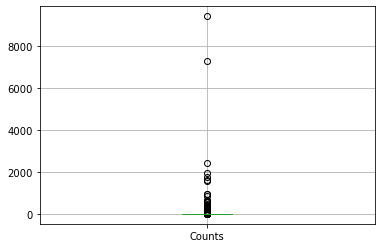

In [12]:
#box plot of genres
boxplot = genre_df_sorted.boxplot()

### 13. Create a list of genre counts of each movie

In [13]:
#Storing the count of genres in each movie in the list genre_quest_count
genre_quest_count = genre_dtm.sum(axis=1).tolist()
#Converting list of lists into single list
genre_quest_count = [j for i in genre_quest_count for j in i]
print('We have tatal {} datapoints.'.format(len(genre_quest_count)))
print(genre_quest_count[:5])
print("Maximum no of genres per movie: %d"%max(genre_quest_count))
print("Minimum no of genres per movie: %d"%min(genre_quest_count))
print("Average no of genres per movie: %f"%((sum(genre_quest_count)*1.0)/len(genre_quest_count)))

We have tatal 28813 datapoints.
[1, 1, 1, 4, 2]
Maximum no of genres per movie: 25
Minimum no of genres per movie: 1
Average no of genres per movie: 1.383264


### 14. Plot a graph of number of genres against number of movies for each number of genres

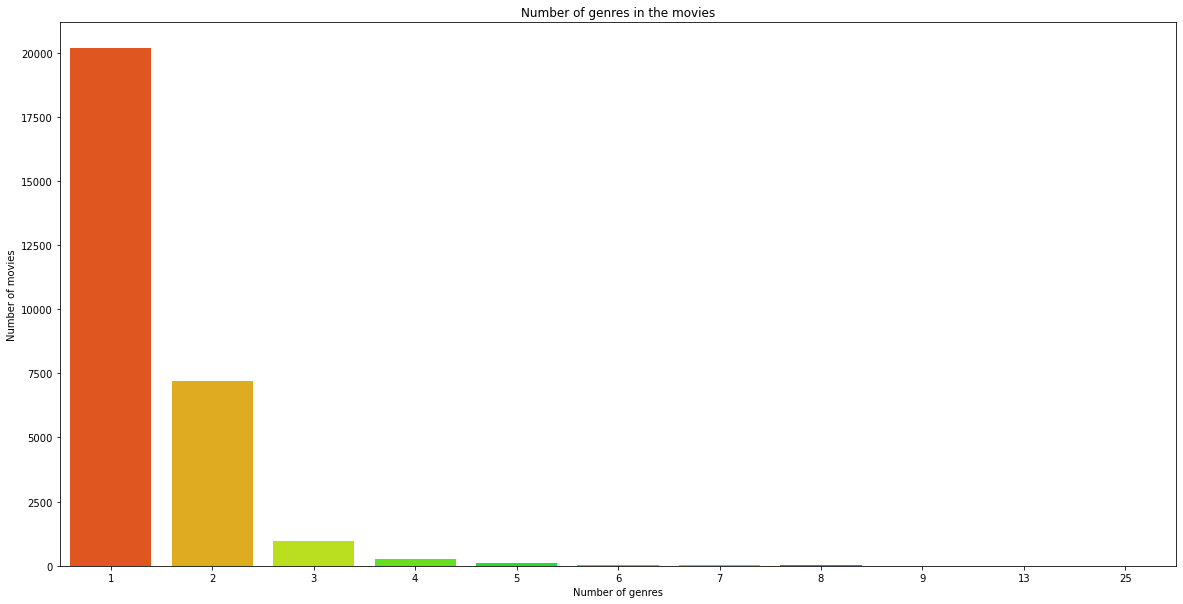

In [14]:
#Count number of genres of each movie
fig = plt.figure(figsize=(20,10))
sns.countplot(genre_quest_count, palette='gist_rainbow')
plt.title("Number of genres in the movies")
plt.xlabel("Number of genres")
plt.ylabel("Number of movies")
plt.show()

### 15. Plot a graph of top and bottom 20 genres

<Figure size 1440x720 with 0 Axes>

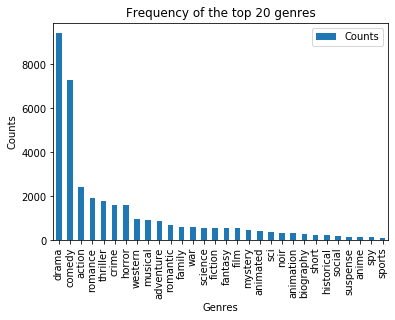

<Figure size 1440x720 with 0 Axes>

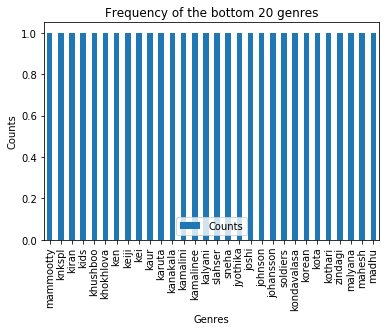

In [12]:
#top 20 genres
i=np.arange(30)
fig = plt.figure(figsize=(20,10))
genre_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of the top 20 genres')
plt.xticks(i,genre_df_sorted['Genres'])
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.show()

genre_df_sorted_least = genre_df.sort_values(['Counts'],ascending=True)
fig = plt.figure(figsize=(20,10))
genre_df_sorted_least.head(30).plot(kind='bar')
plt.title('Frequency of the bottom 20 genres')
plt.xticks(i,genre_df_sorted_least['Genres'])
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.show()

### 16. Use word clound to get a visual view of the frequency distribution of each genre

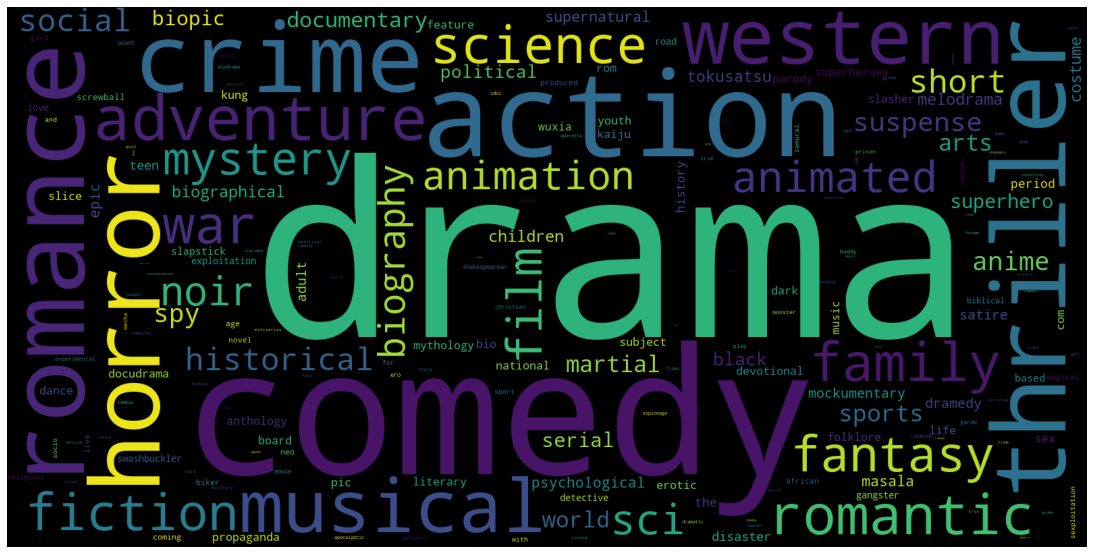

In [16]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Start with one review:
#text = str(movie_data.Genre)
tup = dict(result.items())
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='black',width=1600,height=800,).generate_from_frequencies(tup)

# Display the generated image:
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

### 17. Get some movie plot before data processing

In [13]:
print('Plot before data cleaning',movie_data['Plot'][:5].values)

#Basic information of the plot 
basic_feats = pd.DataFrame()
basic_feats["Plot Length"] = movie_data['Plot'].apply(lambda x: len(str(x)))
basic_feats["Word Count"] = movie_data['Number of words'].astype(float)
basic_feats.describe()

Plot before data cleaning ["The film opens with two bandits breaking into a railroad telegraph office, where they force the operator at gunpoint to have a train stopped and to transmit orders for the engineer to fill the locomotive's tender at the station's water tank. They then knock the operator out and tie him up. As the train stops it is boarded by the bandits?€??€??€?now four. Two bandits enter an express car, kill a messenger and open a box of valuables with dynamite; the others kill the fireman and force the engineer to halt the train and disconnect the locomotive. The bandits then force the passengers off the train and rifle them for their belongings. One passenger tries to escape but is instantly shot down. Carrying their loot, the bandits escape in the locomotive, later stopping in a valley where their horses had been left.\r\nMeanwhile, back in the telegraph office, the bound operator awakens, but he collapses again. His daughter arrives bringing him his meal and cuts him fr

,Plot Length,Word Count
count,27804.000000,27800.000000
mean,2244.720184,383.331835
std,1804.103402,310.425830
min,3.000000,1.000000
25%,751.000000,128.000000
50%,1809.500000,308.000000
75%,3505.250000,597.000000
max,29927.000000,5224.000000


### 18. Define a function of punctuation removal

In [18]:
#function to remove punctuation
import string
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

### 19. Movie plot data processing

In [19]:
#Feature extraction of the plot
from textblob import Word
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer (r'\w+')

movie_data['Plot'].dropna(inplace=True)
movie_data['Plot'] = movie_data['Plot'].apply(lambda x: " ".join(x.lower() for x in x.split()))
stop = stopwords.words('english')
movie_data['Plot'] = movie_data['Plot'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

movie_data['Plot'] = movie_data['Plot'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
movie_data['Plot'] = movie_data['Plot'].apply(lambda x: remove_punctuation(x))
print('Plot after data cleaning',movie_data['Plot'][:5].values)

Plot after data cleaning ['film open two bandit breaking railroad telegraph office force operator gunpoint train stopped transmit order engineer fill locomotives tender stations water tank knock operator tie up train stop boarded bandits€€€now four two bandit enter express car kill messenger open box valuable dynamite others kill fireman force engineer halt train disconnect locomotive bandit force passenger train rifle belongings one passenger try escape instantly shot down carrying loot bandit escape locomotive later stopping valley horse left meanwhile back telegraph office bound operator awakens collapse again daughter arrives bringing meal cut free restores consciousness dousing water comic relief dance hall eastern stranger forced dance local fire feet door suddenly open telegraph operator rush tell robbery men quickly form posse overtakes bandits final shootout kill recovers stolen mail'
 'film family move suburbs hoping quiet life thing start go wrong wife get violent start thro

### 20. Get some basic information of the movie plot and title texts

In [20]:
#Basic information of the plot and title
basic_feats = pd.DataFrame()
basic_feats["Title Length"] = movie_data['Title'].apply(lambda x: len(str(x)))
basic_feats["Plot Length"] = movie_data['Plot'].apply(lambda x: len(str(x)))
basic_feats.describe()

,Title Length,Plot Length
count,27804.000000,27804.000000
mean,15.793591,1514.157495
std,9.286955,1204.597027
min,1.000000,3.000000
25%,10.000000,512.000000
50%,14.000000,1224.000000
75%,19.000000,2359.000000
max,351.000000,19960.000000


### 21. Plot distribution graph of title and plot

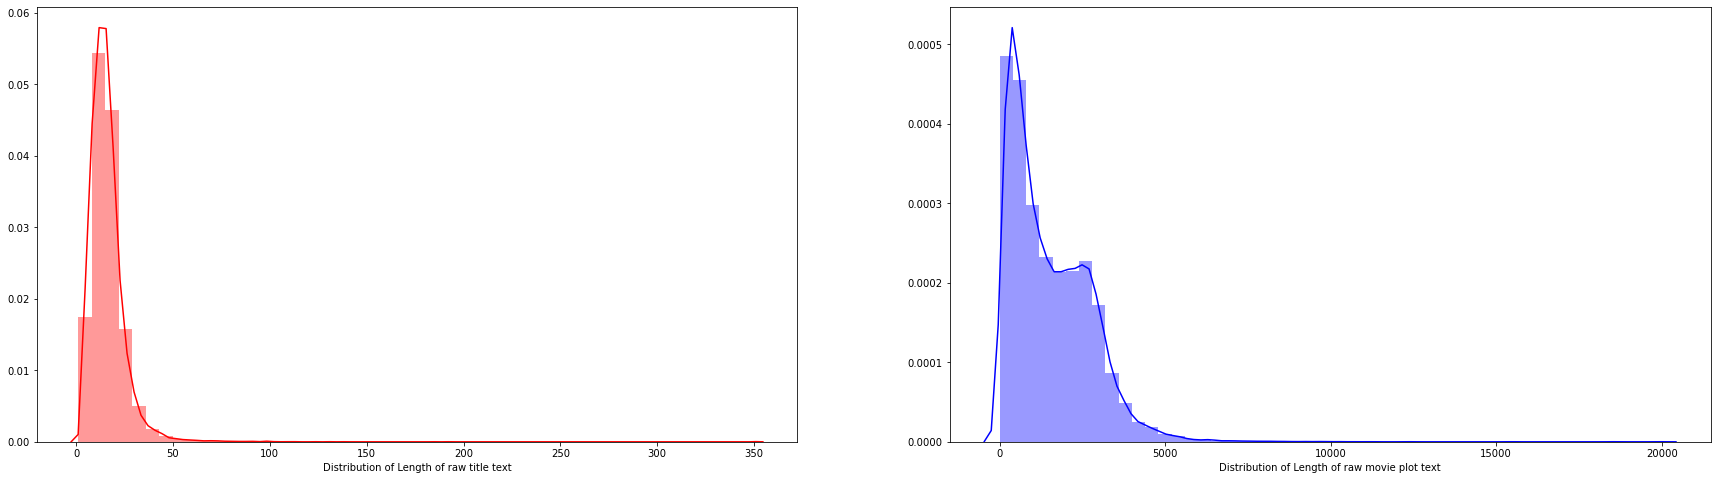

In [21]:
#distrabution of title and plot summary
plt.figure(figsize=(30, 8))
plt.subplot(1,2,1)
sns.distplot([basic_feats['Title Length']], color = 'red', axlabel="Distribution of Length of raw title text")
plt.subplot(1,2,2)
sns.distplot([basic_feats['Plot Length']], color = 'blue', axlabel="Distribution of Length of raw movie plot text")

### 22. Plot a graph of top 100 most frequent words

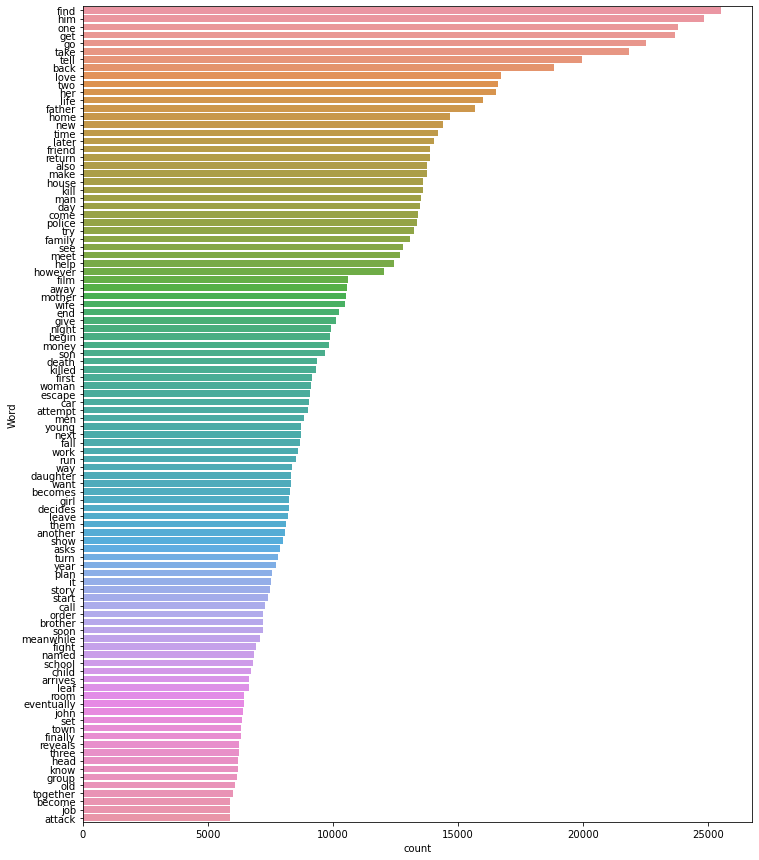

In [22]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 100 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(movie_data['Plot'], 100)

### 23. Split the dataset into training and test set

In [23]:
x=movie_data['Plot']
y=movie_data['Genre']
#Split data into traning and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=42)
movie_data.shape

(27804, 9)

### 24. Vectorize genre data with CountVectorizer

In [24]:
#vectorise genres
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer (r'\w+')
vectorizer = CountVectorizer(tokenizer = lambda x: tokenizer.tokenize(x),
                             binary = 'true', max_features=3)
y_train_vect = vectorizer.fit_transform(y_train)
y_test_vect = vectorizer.transform(y_test)

### 25. Vectorize plot data with TfidfVectorizer

In [25]:
#Perform a n-gram combination of plot vectors
start = datetime.now()

vectorizer = TfidfVectorizer(max_features = 15000,strip_accents='unicode', analyzer='char', 
                             sublinear_tf=False, ngram_range=(3,8))

#x_train_ngram = vectorizer.fit_transform(X_train).todense()
#x_test_ngram = vectorizer.fit_transform(X_test).todense()
x_train_ngram = vectorizer.fit_transform(X_train)
x_test_ngram = vectorizer.fit_transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:45.658574


### 26. Import a pre-trained data set from google for word embedding

In [26]:
#Import the required libraries and load the
'''from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
word2vec_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 
word2vec_words = list(word2vec_model.wv.vocab)'''

"from gensim.models import Word2Vec\nfrom gensim.models import KeyedVectors\nfrom tqdm import tqdm\nword2vec_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) \nword2vec_words = list(word2vec_model.wv.vocab)"

### 27. Find the average Word2Vec vectors of all plot and save them into files
It is commented out as the method takes an extremely long time to run (approximately 10 hours)

In [27]:
#This method returns the Average Word2Vec vectors for all plots in a given dataset
'''def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Computing the average word2vec for each plot
    sent_vectors = []; #A list to store average vector for each plot
    for sentence in tqdm(word2vec_corpus): #For each plot in the dataset
        sent_vec = np.zeros(300) #300 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #Stores the count of the words with a valid vector in each plot text
        for word in sentence: #For each word in a given plot.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Assign a vector for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors
x_train_ngram = vectorize_w2v(X_train, word2vec_model, word2vec_words)
x_test_ngram = vectorize_w2v(X_test, word2vec_model, word2vec_words)
import pickle
with open('X_train_W2V.pkl', 'wb',encoding='utf-8') as file:
    pickle.dump(x_train_ngram, file)
    
with open('X_test_W2V.pkl', 'wb',encoding='utf-8') as file:
    pickle.dump(x_test_ngram, file)'''

'def vectorize_w2v(dataset, word2vec_model, word2vec_words):\n    word2vec_corpus=[]\n    for sentence in dataset:\n        word2vec_corpus.append(sentence.split()) \n    \n    # Creating average Word2Vec model by computing the average word2vec for each review.\n    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list\n    for sentence in tqdm(word2vec_corpus): #For each review\n        sent_vec = np.zeros(300) #300 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.\n        count_words =0; #This will store the count of the words with a valid vector in each review text\n        for word in sentence: #For each word in a given review.\n            if word in word2vec_words:\n                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 300 dimensions) for each word.\n                sent_vec += word_vectors\n                count_words += 1\n        i

### 28. Load vectorized data from files

In [28]:
'''import pickle
   
x_train_ngram = pickle.load( open( 'X_train_W2V.pkl', 'rb' ) )
x_test_ngram = pickle.load( open( 'X_test_W2V.pkl', 'rb' ) )'''

"import pickle\n   \nx_train_ngram = pickle.load( open( 'X_train_W2V.pkl', 'rb' ) )\nx_test_ngram = pickle.load( open( 'X_test_W2V.pkl', 'rb' ) )"

### 29. Use grid search to find the best alpha value for SGDClassifier

In [29]:
#Train the algorithm and find best parameter
from sklearn.model_selection import GridSearchCV

classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'))

parameters = {"estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0]}

gsv = GridSearchCV(classifier, param_grid=parameters, scoring='f1_micro', n_jobs=-1)

gsv.fit(x_train_ngram, y_train_vect)

print(gsv.best_score_)
print(gsv.best_params_)

0.5731201049114627
{'estimator__alpha': 0.0001}


### 30. Testing on various models and evaluate the result

In [30]:
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.adapt import MLkNN
#Test the data and print out the scores
#classifier = OneVsRestClassifier(SGDClassifier(alpha=0.0005,loss='perceptron', penalty='l2', class_weight='balanced'))
#classifier = BinaryRelevance(SGDClassifier(alpha=0.0009,loss='log', penalty='l2', class_weight='balanced'))
classifier = ClassifierChain(SGDClassifier(alpha=0.0002,loss='log', penalty='l2', class_weight='balanced'))
#classifier = OneVsRestClassifier(LogisticRegression(multi_class='multinomial'))
#classifier = OneVsRestClassifier(naive_bayes.MultinomialNB())
#classifier = OneVsRestClassifier(XGBClassifier())
#classifier = OneVsRestClassifier(GaussianNB())
#classifier = MLkNN(k=10)
classifier.fit(x_train_ngram, y_train_vect)
predictions = classifier.predict (x_test_ngram)
print("Accuracy: ", metrics.accuracy_score(y_test_vect,predictions))
print("Hamming loss: ", metrics.hamming_loss(y_test_vect,predictions))

precision = precision_score(y_test_vect, predictions, average='micro')
recall = recall_score(y_test_vect, predictions, average='micro')
f1 = f1_score(y_test_vect, predictions, average='micro')

print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall:{:.4f},F1-measure:{:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_vect, predictions, average='macro')
recall = recall_score(y_test_vect, predictions, average='macro')
f1 = f1_score(y_test_vect, predictions, average='macro')

print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall:{:.4f},F1-measure:{:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_vect, predictions))

Accuracy:  0.3549721273152311
Hamming loss:  0.29748846130791823
Micro-average quality numbers
Precision: 0.3852, Recall:0.5605,F1-measure:0.4566
Macro-average quality numbers
Precision: 0.4310, Recall:0.4337,F1-measure:0.3628

Classification Report
              precision    recall  f1-score   support

           0       0.48      0.09      0.15       472
           1       0.45      0.45      0.45      1391
           2       0.36      0.77      0.49      1857

   micro avg       0.39      0.56      0.46      3720
   macro avg       0.43      0.43      0.36      3720
weighted avg       0.41      0.56      0.43      3720
 samples avg       0.37      0.36      0.36      3720

